# Clinical Text Classification

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
## path to the data
train_path = '/content/gdrive/My Drive/mtsamples.csv'

In [4]:
# install required libraries
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 30.4 MB/s eta 0:00:00


In [5]:
## Checking the gpu device
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import libraries

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')

#plot
import matplotlib.pyplot as plt
import seaborn as sns

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data loading and pre-processing

In [7]:
medical_data = pd.read_csv(train_path, index_col=0)

In [8]:
len(medical_data)

4999

In [9]:
## getting only the required data from the dataframe
medical_data = medical_data[['transcription','medical_specialty']]
medical_data.dropna(inplace=True)

In [11]:
len(medical_data)

4966

In [13]:
## removing duplicate transcriptions
medical_data = medical_data.drop_duplicates(subset=['transcription'], keep='first')

In [14]:
len(medical_data)

2357

In [15]:
## removing notes
notes_list = [' Letters', ' SOAP / Chart / Progress Notes', ' Emergency Room Reports',
              ' Discharge Summary', ' Consult - History and Phy.', ' Office Notes']
medical_data = medical_data[~medical_data['medical_specialty'].isin(notes_list)]

In [16]:
len(medical_data)

2076

In [17]:
## list of medical specialties present in the data
medical_data['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' Sleep Medicine', ' Rheumatology', ' Radiology',
       ' Psychiatry / Psychology', ' Podiatry',
       ' Physical Medicine - Rehab', ' Pediatrics - Neonatal',
       ' Pain Management', ' Orthopedic', ' Ophthalmology',
       ' Obstetrics / Gynecology', ' Neurosurgery', ' Nephrology',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Dermatology', ' Cosmetic / Plastic Surgery', ' Chiropractic',
       ' Autopsy'], dtype=object)

In [18]:
## count for each specialty
medical_data.groupby('medical_specialty').count()['transcription'].reset_index()

,medical_specialty,transcription
0,Allergy / Immunology,1
1,Autopsy,8
2,Bariatrics,10
3,Cardiovascular / Pulmonary,26
4,Chiropractic,2
5,Cosmetic / Plastic Surgery,2
6,Dentistry,1
7,Dermatology,4
8,ENT - Otolaryngology,16
9,Endocrinology,1


In [ ]:
#medical_data = medical_data.groupby('medical_specialty').filter(lambda x : len(x)>20)

In [19]:
## merging ' Cosmetic / Plastic Surgery' and ' Dermatology' into one category
medical_data = medical_data.replace(' Cosmetic / Plastic Surgery',' Dermatology')
label_count = medical_data.groupby('medical_specialty').count()['transcription'].reset_index()
label_count

,medical_specialty,transcription
0,Allergy / Immunology,1
1,Autopsy,8
2,Bariatrics,10
3,Cardiovascular / Pulmonary,26
4,Chiropractic,2
5,Dentistry,1
6,Dermatology,6
7,ENT - Otolaryngology,16
8,Endocrinology,1
9,Gastroenterology,31


Text(0, 0.5, 'samples')

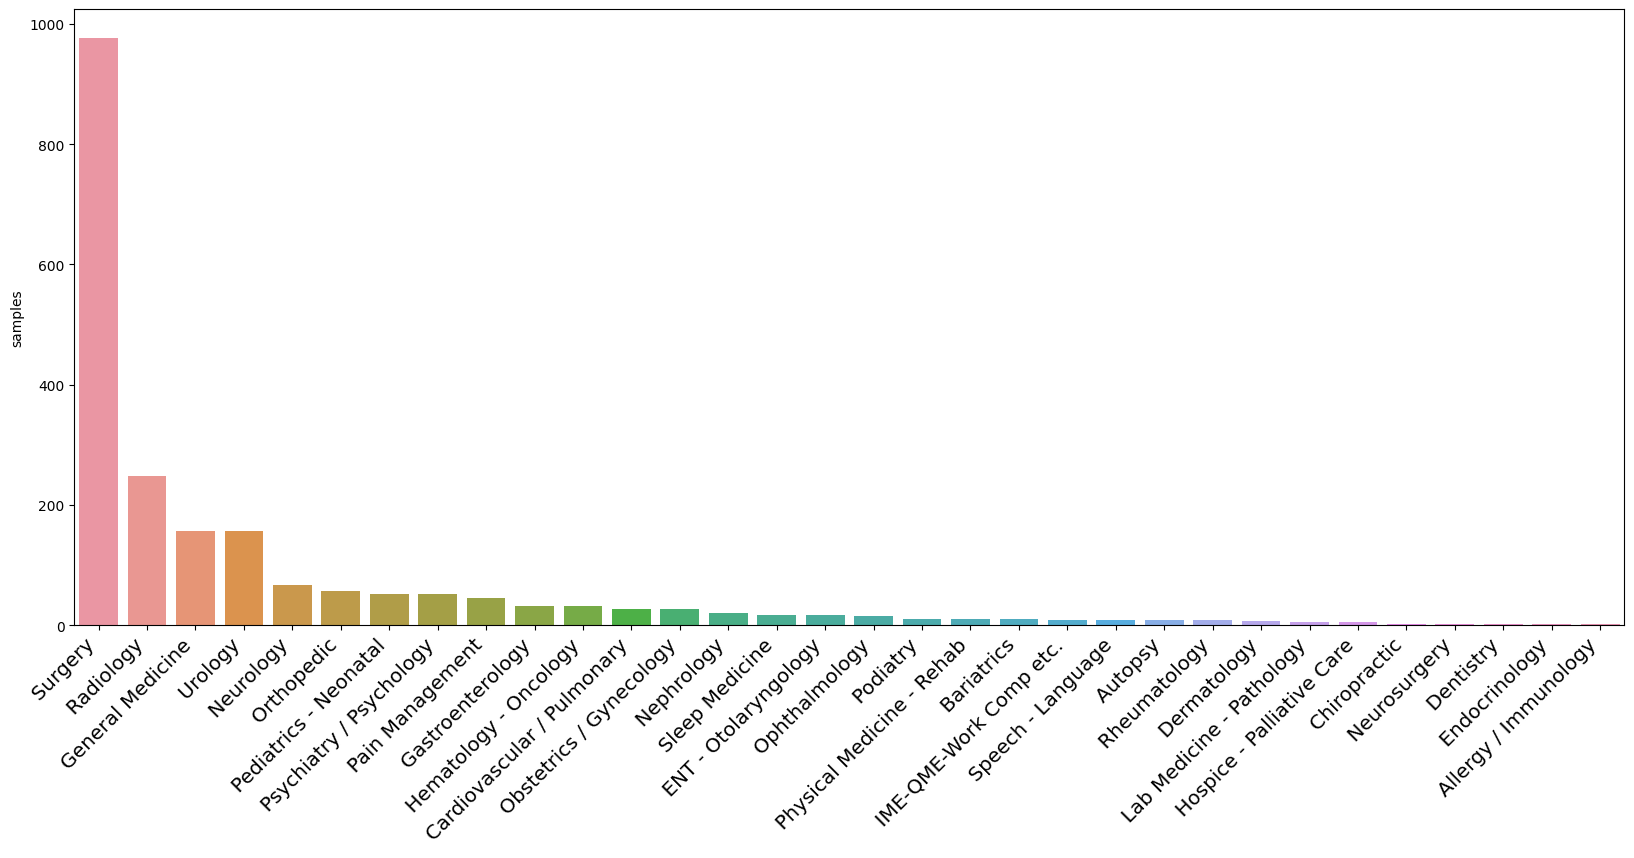

In [20]:
## bar plot for the number of cases for each specialty
plt.figure(figsize=(20,8))
x = medical_data.medical_specialty.value_counts()
sns.barplot(x=x.index,y=x)
#plt.tight_layout()
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
)
plt.gca().set_ylabel('samples')

## Data Augmentation

In [22]:
## data augmentation to increase the number of samples to balance the data
aug = naw.SynonymAug(aug_src='wordnet',aug_max= 24)
for i in range(0, len(label_count)-1):
    aug_val = int(round(label_count.transcription.max() / label_count.transcription[i],0)) - 1
    filtered_data = medical_data.loc[medical_data['medical_specialty'] == label_count.medical_specialty[i]]
    for j in filtered_data.index:
        temps=aug.augment(filtered_data.transcription[j],n=aug_val)
        for sent in temps:
            medical_data1 = {'transcription': sent, 'medical_specialty': label_count.medical_specialty[i]}
            medical_data = medical_data.append(medical_data1, ignore_index = True)
    #print(medical_data.shape)

Streaming output truncated to the last 5000 lines.
<ipython-input-22-05803fd8790b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medical_data = medical_data.append(medical_data1, ignore_index = True)
<ipython-input-22-05803fd8790b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medical_data = medical_data.append(medical_data1, ignore_index = True)
<ipython-input-22-05803fd8790b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medical_data = medical_data.append(medical_data1, ignore_index = True)
<ipython-input-22-05803fd8790b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medical_data = medical_data.append(medical_data1, ignore

In [23]:
medical_data.groupby('medical_specialty').count()['transcription'].reset_index()

,medical_specialty,transcription
0,Allergy / Immunology,976
1,Autopsy,976
2,Bariatrics,980
3,Cardiovascular / Pulmonary,988
4,Chiropractic,976
5,Dentistry,976
6,Dermatology,978
7,ENT - Otolaryngology,976
8,Endocrinology,976
9,Gastroenterology,961


Text(0, 0.5, 'samples')

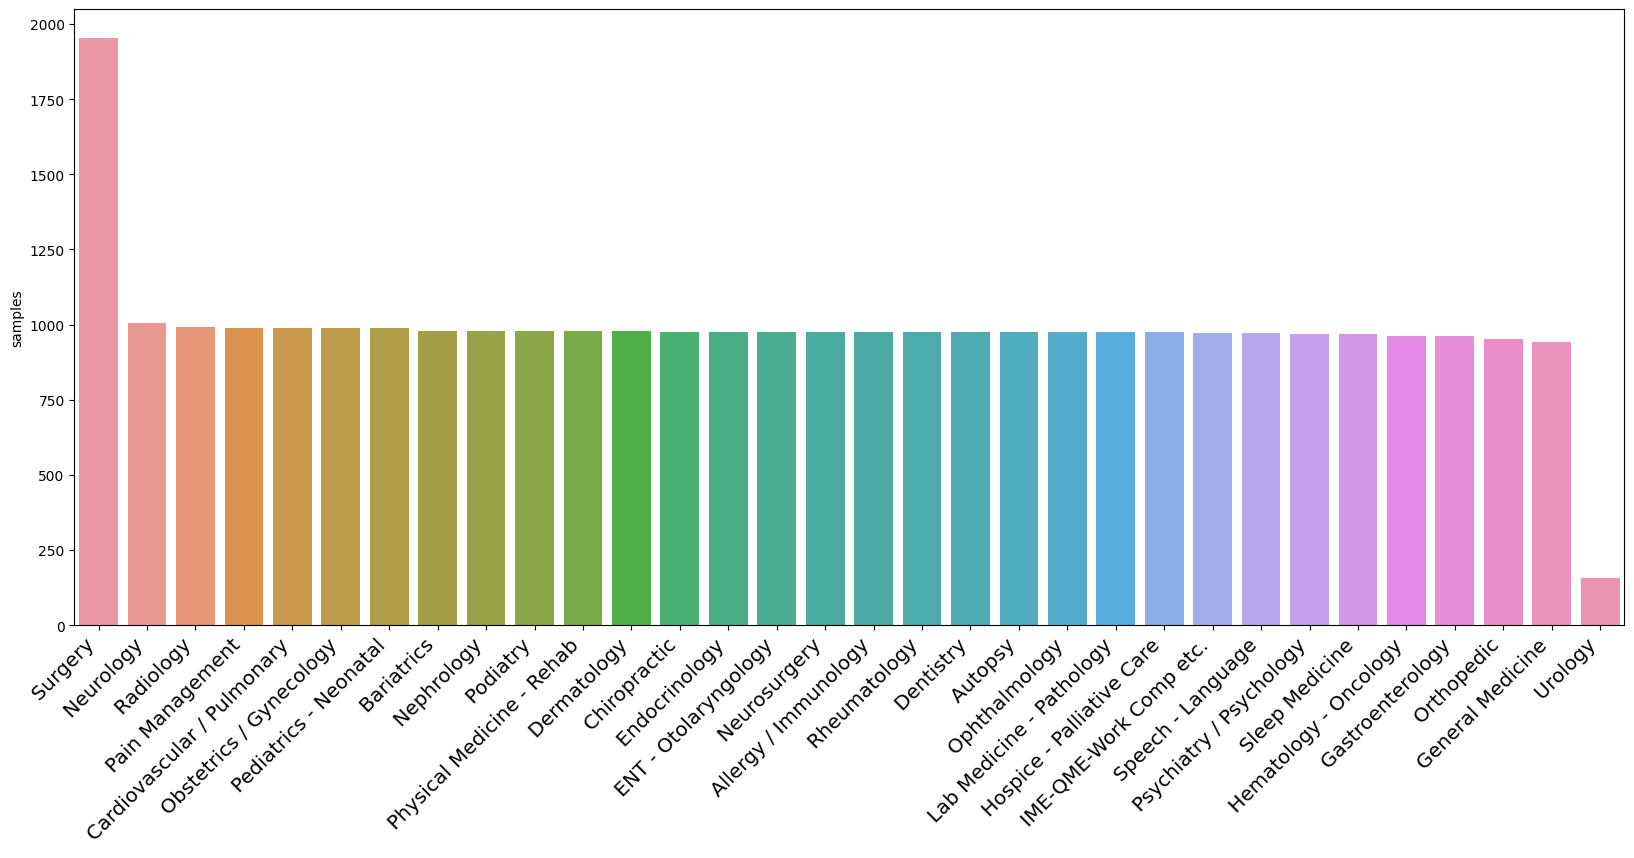

In [24]:
plt.figure(figsize=(20,8))
x = medical_data.medical_specialty.value_counts()
sns.barplot(x=x.index,y=x)
#plt.tight_layout()
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
)
plt.gca().set_ylabel('samples')

## Text pre-processing

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
import regex as re
import string

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [27]:
def text_preprocessing(data):
    data = str(data).lower()
    data = re.sub('\[.*?\]', '', data)
    data = re.sub('https?://\S+|www\.\S+', '', data)
    data = re.sub('<.*?>+', '', data)
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    return data

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])
medical_data["transcription"] = medical_data["transcription"].apply(lambda text: text_preprocessing(text))
medical_data["transcription"] = medical_data["transcription"].apply(lambda text: remove_stopwords(text))
medical_data['tr_word_count']= medical_data['transcription'].apply(lambda x: len(str(x).split(' ')))

In [31]:
Y = pd.get_dummies(medical_data['medical_specialty']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (31388, 32)


array([[<Axes: title={'center': 'tr_word_count'}>]], dtype=object)

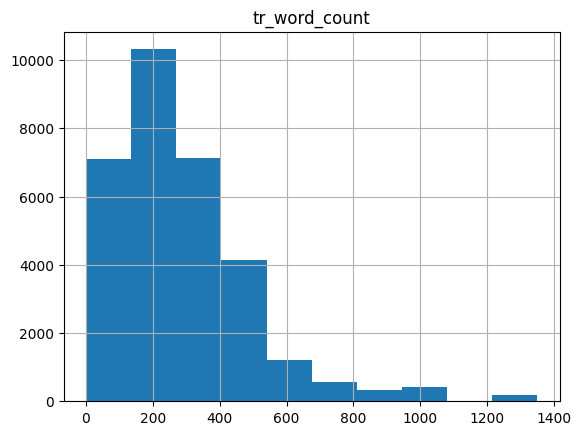

In [32]:
medical_data.hist(column = 'tr_word_count')

In [33]:
documents = []

for doc in medical_data['transcription']:
    documents.append(doc.split(' '))

## Word2Vec model

In [35]:
from gensim.models import Word2Vec
# Training the Word2Vec model
model = Word2Vec(documents, #Word list
                   min_count=5, #Ignore all words with total frequency lower than this
                   workers=4, #Number of CPUs
                   vector_size=100,  #Embedding size
                   window=5 #Maximum Distance between current and predicted word
                  )

In [37]:
#How many words in the model and how many features
model.wv.vectors.shape

(21115, 100)

In [38]:
all_words = model.wv.index_to_key               #key_to_index
top_words = model.wv.index_to_key[0:5]
top_words

['patient', 'history', 'right', 'left', 'pain']

In [39]:
print('Vocabulary size: %d' % len(all_words))

Vocabulary size: 21115


In [40]:
# Most similar words
similar = model.wv.most_similar('anesthetic')
similar

[('anaesthetic', 0.8365791440010071),
 ('anaesthesia', 0.7502128481864929),
 ('anesthesia', 0.6734403371810913),
 ('local', 0.6348485946655273),
 ('sedation', 0.6340336203575134),
 ('interscalene', 0.6154155135154724),
 ('drugging', 0.6002509593963623),
 ('anesthesiology', 0.5959843993186951),
 ('endotracheal', 0.5939881801605225),
 ('retrobulbar', 0.5899298191070557)]

In [41]:
model.save("word2vec_Medical Specialty Classification6")

## Data split

In [42]:
from sklearn.model_selection import train_test_split
X = medical_data['transcription']
y = Y
#train test validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify = y_train)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(18832,)
(6278,)
(18832, 32)
(6278, 32)
(6278,)
(6278, 32)


In [46]:
# building tokenizer to form a token for each word in each transcription

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [47]:
#Convert words to integers

top_words = 10000 #reducing no of words to increase the processing speed

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

In [48]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

In [49]:
# pad sequenc to make each transcription of the same size
#taking 300  based on avg length of the transcription form histogram
padding_max_len = 300

X_train = pad_sequences(X_train, maxlen=padding_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=padding_max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=padding_max_len, padding='post')

In [50]:
# Building embedding matrix from above Word2Vec model(pre trained model)

word2vec_model = Word2Vec.load("word2vec_Medical Specialty Classification6")  #loading the one created above

In [51]:
word2vec_model.wv.vectors.shape

(21115, 100)

In [52]:
#embedding length
embedding_vector_length = word2vec_model.wv.vectors.shape[1]
embedding_vector_length

100

In [53]:
# building embedding matrix
#initailiazing matrix to all zeros

embedding_matrix = np.zeros((top_words+1, embedding_vector_length))

tokenizer.word_index.items()

for word,i in sorted(tokenizer.word_index.items(), key = lambda x:x[1]):
  if i > top_words:
    break
  if word in word2vec_model.wv.index_to_key:
    #print(word)
    embedding_vector = word2vec_model.wv[word]
    #print(embedding_vector)
    embedding_matrix[i] = embedding_vector
    #print(embedding_matrix[i])

In [54]:
# Create an embedding layer
#Output from Embedding is 3 dimension
#batch_size x max_review_length x embedding_vector_length

embedding_layer = Embedding(top_words+1, embedding_vector_length, weights=[embedding_matrix],
                             input_length=padding_max_len,trainable=False)

## Model Training

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Embedding,LSTM ,Bidirectional
from tensorflow.keras import regularizers

In [56]:
model = Sequential()

model.add(embedding_layer)

model.add(Bidirectional(LSTM(32 , dropout=0.1, recurrent_dropout=0.1)))

model.add(Dense(units=32,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000100   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
Total params: 1,036,228
Trainable params: 36,128
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [57]:
model_history = model.fit(X_train, y_train, batch_size=100, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
189/189 [==============================] - 490s 3s/step - loss: 2.2702 - accuracy: 0.4970 - val_loss: 1.3189 - val_accuracy: 0.7214
Epoch 2/15
189/189 [==============================] - 488s 3s/step - loss: 0.9861 - accuracy: 0.7956 - val_loss: 0.6446 - val_accuracy: 0.8676
Epoch 3/15
189/189 [==============================] - 479s 3s/step - loss: 0.5604 - accuracy: 0.8894 - val_loss: 0.3923 - val_accuracy: 0.9224
Epoch 4/15
189/189 [==============================] - 486s 3s/step - loss: 0.3709 - accuracy: 0.9287 - val_loss: 0.2722 - val_accuracy: 0.9487
Epoch 5/15
189/189 [==============================] - 479s 3s/step - loss: 0.2659 - accuracy: 0.9520 - val_loss: 0.1983 - val_accuracy: 0.9630
Epoch 6/15
189/189 [==============================] - 483s 3s/step - loss: 0.2046 - accuracy: 0.9637 - val_loss: 0.1544 - val_accuracy: 0.9691
Epoch 7/15
189/189 [==============================] - 484s 3s/step - loss: 0.1636 - accuracy: 0.9699 - val_loss: 0.1273 - val_accuracy: 0.9740

In [58]:
model.save_weights('/content/gdrive/My Drive/lstm4_2.h5')

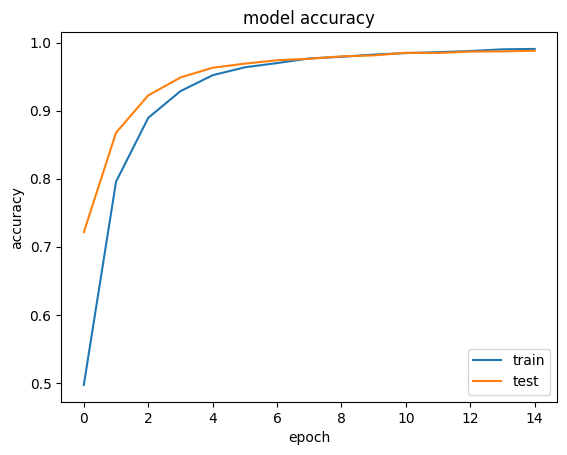

In [59]:
from matplotlib import pyplot as plt
# visualise training history
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

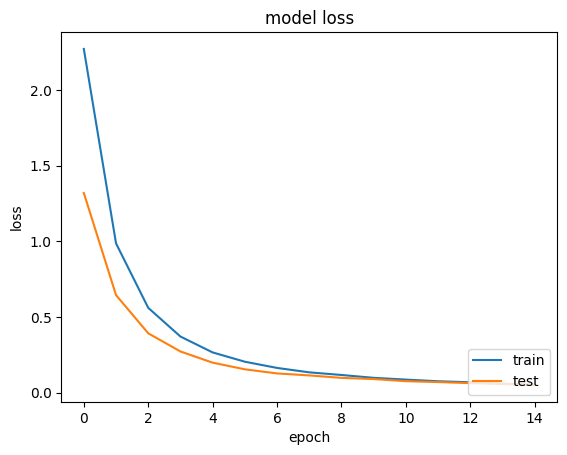

In [60]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Model Evaluation

In [62]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=medical_data['medical_specialty'].unique()))

197/197 [==============================] - 38s 188ms/step
                             precision    recall  f1-score   support

       Allergy / Immunology       1.00      1.00      1.00       195
                 Bariatrics       1.00      1.00      1.00       195
 Cardiovascular / Pulmonary       1.00      1.00      1.00       196
                  Neurology       0.98      0.99      0.99       198
                  Dentistry       0.99      1.00      1.00       195
                    Urology       1.00      1.00      1.00       195
           General Medicine       1.00      1.00      1.00       196
                    Surgery       0.99      1.00      1.00       195
          Speech - Language       1.00      1.00      1.00       195
             Sleep Medicine       0.99      0.99      0.99       192
               Rheumatology       0.95      0.96      0.96       188
                  Radiology       1.00      0.99      0.99       192
    Psychiatry / Psychology       1.00      